In [5]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
import pickle
import time
from typing import Optional

In [6]:
def plot_st(st_matrix, f, title="Stockwell Transform"):
    plt.figure(figsize=(12, 8))

    extent = [0, st_matrix.shape[1], 0, f]

    plt.imshow(
        np.abs(st_matrix),
        extent=extent,
        aspect='auto',
        origin='lower',
        cmap='viridis'
    )

    plt.colorbar(label="Magnitude")
    plt.xlabel("Time")
    plt.ylabel("Frequency")

    plt.yscale("log")
    plt.ylim(max(0.05, 0), f)

    plt.title(title)
    plt.tight_layout()
    plt.show()


def stockwell_chunked_vectorized(
    x: np.ndarray,
    dt: float,
    kmin: int = 0,
    kmax: Optional[int] = None,
    kstep: int = 1,
    chunk_size: int = 256,
    out_dtype=np.complex128,
    mmap_path: Optional[str] = None,
):
    """
    Fully vectorized + corrected Stockwell transform
    that matches your original implementation EXACTLY,
    but processes frequencies in chunks (memory efficient).
    """

    x = np.asarray(x)
    n = x.size

    if kmax is None:
        kmax = n // 2

    # Build frequency bins
    k_bins = np.arange(kmin, kmax + 1, kstep, dtype=int)
    num_k  = len(k_bins)

    # Output matrix (optionally memmapped)
    if mmap_path is None:
        S = np.zeros((num_k, n), dtype=out_dtype)
    else:
        S = np.memmap(mmap_path, mode="w+", dtype=out_dtype, shape=(num_k, n))

    # Handle DC component
    row_cursor = 0
    if kmin == 0:
        S[0, :] = np.mean(x)
        k_bins = k_bins[1:]
        num_k  = len(k_bins)
        row_cursor = 1

    # Compute FFT once and duplicate to allow wrap slicing
    X = np.fft.fft(x)
    X2 = np.concatenate([X, X])     # length 2n (for no-wrap slicing)

    # Precompute t² vectors identical to original implementation
    t_front = np.arange(n, dtype=float)**2       # 0^2, 1^2, ..., (n-1)^2
    t_back  = np.arange(-n, 0, dtype=float)**2   # n^2, ..., 1^2
    t_vec   = np.concatenate([t_front, t_back])  # length 2n (MATCHES original)

    # Time index array for slicing FFT windows
    cols = np.arange(n)

    # Process frequency bins in chunks
    for i in range(0, num_k, chunk_size):

        k_batch = k_bins[i : i + chunk_size]
        B = len(k_batch)
        if B == 0:
            break

        # Gaussian scaling term: -2π² / k²
        scale = -2.0 * (np.pi ** 2) / (k_batch.astype(float) ** 2)

        # Build Gaussian window EXACTLY matching original:
        # gauss[b,:] = exp(scale[b] * t_front) + exp(scale[b] * t_back)
        voice = scale[:, None] * t_vec[None, :]    # shape (B, 2n)
        gauss = np.exp(voice[:, :n]) + np.exp(voice[:, n:])

        # Vectorized FFT slicing:
        # For each k0, take X2[k0 : k0+n]
        idx_start = k_batch[:, None] + cols[None, :]   # shape (B, n)
        slices = X2[idx_start]                         # <------ VECTORIZED

        # Apply Gaussian window in frequency domain, then inverse FFT
        rows = np.fft.ifft(slices * gauss, axis=1)

        # Store into output
        S[row_cursor:row_cursor + B, :] = rows.astype(out_dtype, copy=False)
        row_cursor += B

        f = kmax/(n*dt)
        
    return S, f


In [7]:
@dataclass
class StationTF:

    HVSRN: np.ndarray | None
    HVSRE: np.ndarray | None

    fullHVSRN: np.ndarray | None
    fullHVSRE: np.ndarray | None

# to speed up. put on GPU. no plotting. float32. bigger chunksize. larger k step. downsampling. limit k max

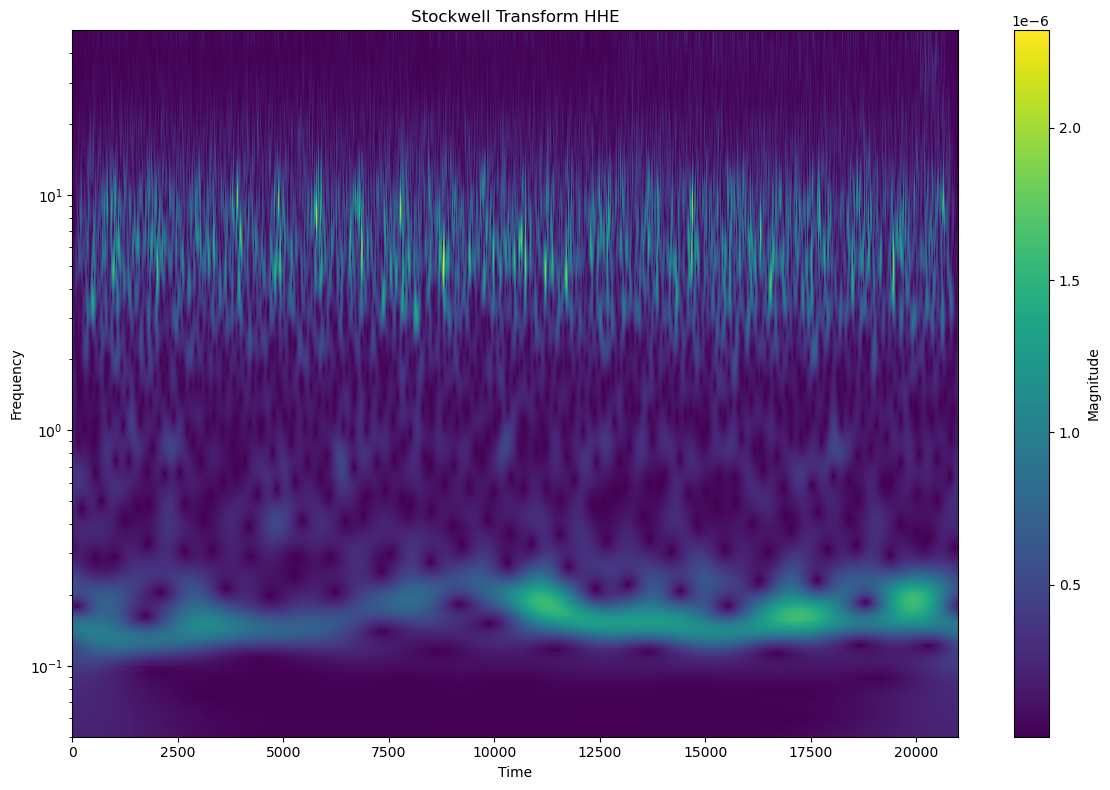

49.997619160992336


In [9]:
with open("stn.pkl", "rb") as f:
    sel_N, sel_E, sel_Z = pickle.load(f)

waveforms_N_data = [xt.data for xt in sel_N]
waveforms_E_data = [xt.data for xt in sel_E]
waveforms_Z_data = [xt.data for xt in sel_Z]

waveforms_N_delta = [st.stats.delta for st in sel_N]
waveforms_E_delta = [st.stats.delta for st in sel_E]
waveforms_Z_delta = [st.stats.delta for st in sel_Z]

#st_matrix_N[0], time_vector_N[0], freq_vector_N[0] = stockwell_chunked_vectorized(waveforms_N_data[0],waveforms_N_delta[0], kmin=0, kmax=len(waveforms_N_data[0])//2, kstep=1, chunk_size=128)
st_matrix_E, k = stockwell_chunked_vectorized(waveforms_E_data[0],waveforms_E_delta[0], kmin=0, kmax=len(waveforms_E_data[0])//2, kstep=1, chunk_size=500)
#st_matrix_Z[0], time_vector_Z[0], freq_vector_Z[0] = stockwell_chunked_vectorized(waveforms_Z_data[0],waveforms_Z_delta[0], kmin=0, kmax=len(waveforms_Z_data[0])//2, kstep=1, chunk_size=128)


plot_st(st_matrix_E, k, title="Stockwell Transform HHE")
print(k)

In [ ]:
res = []

with open("stn.pkl", "rb") as f:
    selN, selE, selZ = pickle.load(f)

waveforms_N_data = [xt.data for xt in selN]
waveforms_E_data = [xt.data for xt in selE]
waveforms_Z_data = [xt.data for xt in selZ]

for idx in range(len(waveforms)):

    st_matrix_N[0], time_vector_N[0], freq_vector_N[0] = stockwell_chunked_vectorized(waveforms_N_data[0],waveforms_N_delta[0], kmin=0, kmax=len(waveforms_N_data[0])//2, kstep=1, chunk_size=128)
    st_matrix_E[0], time_vector_E[0], freq_vector_E[0] = stockwell_chunked_vectorized(waveforms_E_data[0],waveforms_E_delta[0], kmin=0, kmax=len(waveforms_E_data[0])//2, kstep=1, chunk_size=128)
    st_matrix_Z[0], time_vector_Z[0], freq_vector_Z[0] = stockwell_chunked_vectorized(waveforms_Z_data[0],waveforms_Z_delta[0], kmin=0, kmax=len(waveforms_Z_data[0])//2, kstep=1, chunk_size=128)

    

    res.append(StationTF(HVSRE=HVSR2, HVSRN = HVSR1, fullHVSRE=HVSR3, fullHVSRN = HVSR4))

16384
2048
16384
16384
16384
16384
16384
16384
16384
1024
16384
16384


In [77]:
with open("results.pkl", "wb") as f:
    pickle.dump(res, f)